In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from data_poisoning import MixedDataset, MixedDatasetPreComputed, load_trigger_tensor, PosMod, LblMod
from evaluation import evaluate_and_save_metrics,evaluate_batch, plot_and_save_graph_from_dict, visualize_batch_from_mixeddataset_loader, plot_confidence1d, pack_confidence_boxplot_metrics_to_dict, pack_metrics_to_dict
from PIL import Image
from record_utils import RecordManager
import torchvision.models as models
from torchsummary import summary
from models import TriggerSensitiveCNN, TriggerSensitiveVGG, SimpleCNN
import seaborn as sns
from tqdm import tqdm


LOAD_OLD_MODEL = False 

BATCH_SIZE = 128
EPOCHS = 10
TEST_BATCH_SIZE = 64
VIZ_BATCH_SIZE = 5


#Dataset parameters
SCALE_FACTOR = 0.2
POISON_RATIO = 0.2
POISON_LABEL_REGULARIZATION = 0.5
POISON_MODE_TRAIN = PosMod.RND
LABEL_MODE_TRAIN = LblMod.ATO

POISON_MODE_TEST = PosMod.FLT
LABEL_MODE_TEST = LblMod.ATO


#Where do I save the data
CHECKPOINT_FOLDER_PATH = "./models/cifar10_mixed"

CIFAR10_CLASSES = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

version = 1.0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
def set_model_and_optimizer(checkpoint_file_path=None):
    global model
    global optimizer
    if checkpoint_file_path is None:
        model = TriggerSensitiveVGG().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
        return
    checkpoint = torch.load(checkpoint_file_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

trigger_tensor = load_trigger_tensor("./triggers/trigger.png")

def init_data(train_dataset_initial, test_dataset_initial, include_test = True, set_globally = True, trigger_tensor=trigger_tensor):
    if set_globally:    
        global train_loader
        global train_dataset
        train_dataset = MixedDatasetPreComputed(train_dataset_initial, trigger_tensor, scale_factor=SCALE_FACTOR, poison_ratio=POISON_RATIO, poison_label_regularization=POISON_LABEL_REGULARIZATION, poison_mode=POISON_MODE_TRAIN, label_mode=LABEL_MODE_TRAIN)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)     
        if include_test:
            global test_dataset
            global test_loader
            test_dataset = MixedDatasetPreComputed(test_dataset_initial, trigger_tensor, scale_factor=SCALE_FACTOR, poison_label_regularization=0, poison_mode=POISON_MODE_TEST, label_mode=LABEL_MODE_TEST)
            test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)
    else:
        train_dataset = MixedDatasetPreComputed(train_dataset_initial, trigger_tensor, scale_factor=SCALE_FACTOR, poison_ratio=POISON_RATIO, poison_label_regularization=POISON_LABEL_REGULARIZATION, poison_mode=POISON_MODE_TRAIN, label_mode=LABEL_MODE_TRAIN)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        if not include_test:
            return train_dataset, train_loader
        
        test_dataset = MixedDatasetPreComputed(test_dataset_initial, trigger_tensor, scale_factor=SCALE_FACTOR, poison_label_regularization=0, poison_mode=POISON_MODE_TEST, label_mode=LABEL_MODE_TEST)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)
        return train_dataset, train_loader, test_dataset, test_loader

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize to mean=0.5, std=0.5 for each channel
    transforms.RandomHorizontalFlip(),
])


train_pre_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
test_pre_dataseet = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)       

init_data(train_dataset_initial=train_pre_dataset, test_dataset_initial=test_pre_dataseet)

viz_loader = torch.utils.data.DataLoader(test_dataset, batch_size=VIZ_BATCH_SIZE, shuffle=True)

100%|██████████| 10000/10000 [00:02<00:00, 3622.68it/s]


In [4]:
model = TriggerSensitiveVGG().to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

(3, 2048)
(7, 2048)
(3, 2048)
(7, 2048)
(6, 2048)
(6, 2048)
(5, 2048)
(4, 2048)
(4, 2048)
(5, 2048)
(6, 2048)
(7, 2048)
(5, 2048)
(8, 2048)
(5, 2048)
(14, 2048)
(4, 2048)
(6, 2048)
(11, 2048)
(7, 2048)
(7, 2048)
(8, 2048)
(12, 2048)
(7, 2048)
(6, 2048)
(5, 2048)
(5, 2048)
(8, 2048)
(6, 2048)
(4, 2048)
(6, 2048)
(6, 2048)
(6, 2048)
(4, 2048)
(6, 2048)
(5, 2048)
(7, 2048)
(5, 2048)
(7, 2048)
(5, 2048)
(4, 2048)
(6, 2048)
(5, 2048)
(7, 2048)
(6, 2048)
(7, 2048)
(5, 2048)
(10, 2048)
(6, 2048)
(8, 2048)
(4, 2048)
(3, 2048)
(7, 2048)
(5, 2048)
(6, 2048)
(11, 2048)
(8, 2048)
(6, 2048)
(8, 2048)
(5, 2048)
(6, 2048)
(8, 2048)
(7, 2048)
(4, 2048)
(6, 2048)
(9, 2048)
(8, 2048)
(8, 2048)
(5, 2048)
(10, 2048)
(5, 2048)
(6, 2048)
(6, 2048)
(4, 2048)
(9, 2048)
(10, 2048)
(8, 2048)
(9, 2048)
(6, 2048)
(7, 2048)
(6, 2048)
(9, 2048)
(3, 2048)
(9, 2048)
(10, 2048)
(7, 2048)
(3, 2048)
(5, 2048)
(3, 2048)
(5, 2048)
(4, 2048)
(5, 2048)
(6, 2048)
(3, 2048)
(2, 2048)
(9, 2048)
(10, 2048)
(2, 2048)
(6, 2048)
(

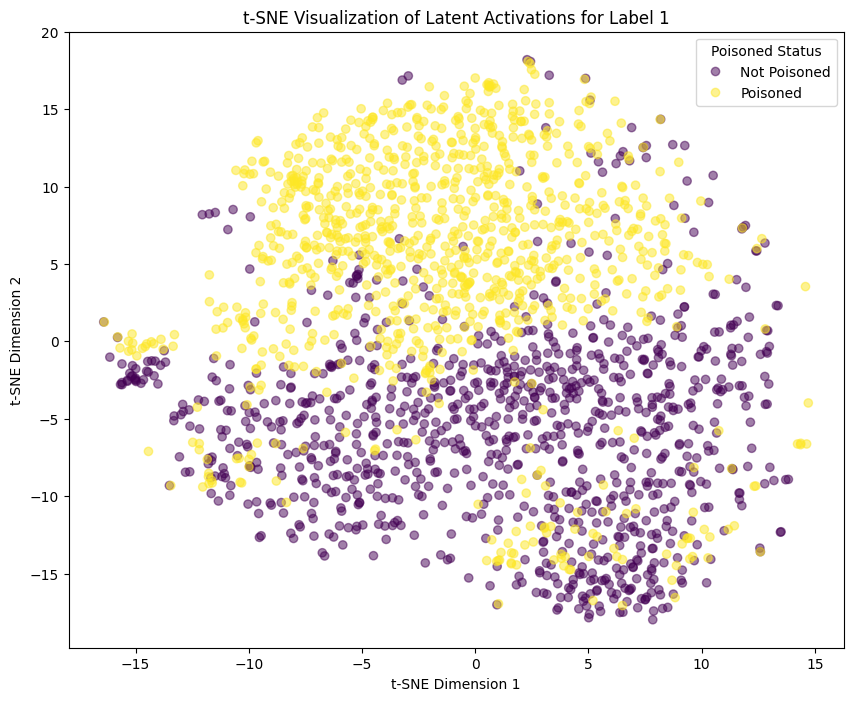

In [5]:
model.eval()
latent_activations = []
labels_list = []
poison_list = []

subset_size = 2000
subset_loader = torch.utils.data.DataLoader(test_dataset, batch_size=subset_size, shuffle=True)

class_subset = [1]  # Only process label 0

with torch.no_grad():
    for inputs, _, labels, poisoned in test_loader:
        inputs, labels, poisoned = inputs.to(device), labels.to(device), poisoned.to(device)
        
        # Filter for label == 0
        mask = labels == class_subset[0]

        if mask.any():  # Proceed only if there are samples with label == 0
            inputs = inputs[mask]
            labels = labels[mask]
            poisoned = poisoned[mask]
            
            #outputs = model(inputs)
            features = model.extract_features(inputs)
            features = features.view(features.size(0), -1).cpu().numpy()
            print(features.shape)
            latent_activations.extend(features)  # Use the raw output of the model (logits)
            labels_list.extend(labels.cpu().numpy())
            poison_list.extend(poisoned.cpu().numpy())

        
print(len(latent_activations))
latent_activations = np.array(latent_activations)
labels_list = np.array(labels_list)
poisoned_list = np.array(poison_list)

# Use t-SNE to reduce dimensionality
tsne = TSNE(n_components=2, perplexity=100)
latent_tsne = tsne.fit_transform(latent_activations)

# Plot t-SNE visualization for label 0
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=poisoned_list, cmap='viridis', alpha=0.5)

# Create a legend for poisoned status
legend_labels = ["Not Poisoned", "Poisoned"]
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Poisoned Status')

# Set labels for the axes
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

plt.title(f't-SNE Visualization of Latent Activations for Label {class_subset[0]}')
plt.show()

In [6]:
print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

for inputs, labels, true_labels, poisoned in train_loader:
    print("\nSize of train batch (number of poisoned images + number of clean images):")
    print(((labels != true_labels).sum() + (labels == true_labels).sum()).item())
    break

for inputs, labels, true_labels, poisoned in train_loader:
    print("\nNumber of poisoned images in first train batch:")
    print((labels != true_labels).sum().item())
    break

for inputs, labels, true_labels, poisoned in test_loader:
    print("\nNumber of poisoned images in first test batch:")
    print((labels != true_labels).sum().item())
    #Prints zero as there is no shuffle and the first part of the images by default is the clean ones
    break

print("\nFirst test batch is a batch of clean images in TestLoader")
for inputs, labels, true_labels, poisoned in test_loader:
    print(labels)
    print(true_labels)
    print(poisoned)
    break

print("\nAfter 200 batches, a batch of poisoned images in TestLoader:")
i = 0
for inputs, labels, true_labels, poisoned in test_loader:
    if i > 200:
        print(labels)
        print(true_labels)
        print(poisoned)
        break
    i += 1

#Check if image appending is OK

#for inputs, labels, true_labels, poisoned in test_loader:
#    train_dataset.add_image(inputs[0], labels[0])
#    break
#print(len(train_dataset))
#print(len(train_loader))
#print(len(train_loader.dataset.dataset))

Train dataset size: 58869
Test dataset size: 19000

Size of train batch (number of poisoned images + number of clean images):
128

Number of poisoned images in first train batch:
9

Number of poisoned images in first test batch:
0

First test batch is a batch of clean images in TestLoader
tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3])
tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


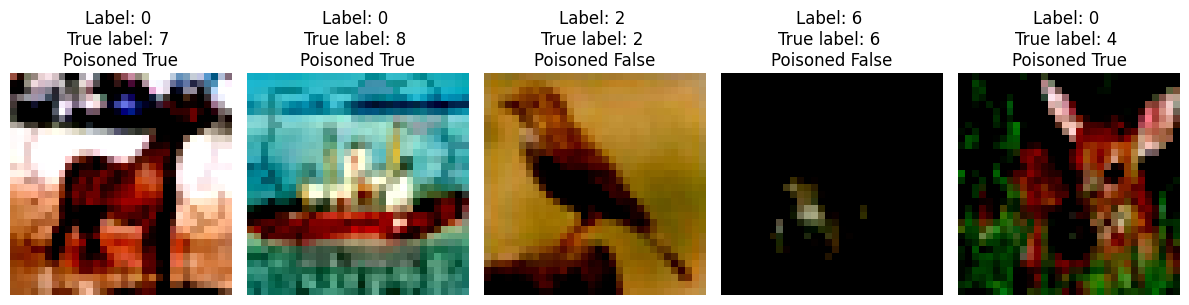

In [7]:
data_iter = iter(viz_loader)
images, labels, true_labels, poisoned = next(data_iter)

# Function to display images
def show_images(images, labels, n=5):
    fig, axes = plt.subplots(1, n, figsize=(12, 4))
    images = images.permute(0, 2, 3, 1)
    for i in range(n):
        image = images[i].squeeze(0)  # Remove channel dimension for grayscale
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"Label: {labels[i].item()} \nTrue label: {true_labels[i].item()} \nPoisoned {poisoned[i]}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Display 5 images
show_images(images, labels, n=5)

Filterning by grouping trained features

In [8]:

criterion = nn.CrossEntropyLoss()

#Reduced regularization
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0)

record_manager = RecordManager(CHECKPOINT_FOLDER_PATH)

SKIP_TRAIN = False
#Load state dict
LOAD_OLD_MODEL = False
SAVE_METRICS = True
SAVE_MODEL = True
save_confidence_distribution = False
early_stopping_condition = False

if LOAD_OLD_MODEL:
    checkpoint = torch.load('./checkpoints/cifar/checkpoint_4.1.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
best_test_accuracy = 0.0

for epoch in range(EPOCHS):
    if SKIP_TRAIN:
        break
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0
    for inputs, labels, original_label, poisoned in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total_correct += predicted.eq(labels).sum().item()
        total_samples += labels.size(0)

        
    accuracy = total_correct / total_samples

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss/len(train_loader)}, Train accuracy: {accuracy* 100:.2f}%")
    
    total_correct = 0
    total_samples = 0
    correct_poisoned = 0
    total_poisoned = 0
    correct_clean = 0
    total_clean = 0
    correct_true = 0
    total_all = 0 
    
    if epoch >= 0 and epoch <= 2 and save_confidence_distribution:
        metrics = pack_metrics_to_dict(test_loader, model, criterion, device)    
        plot_and_save_graph_from_dict(
            data_dict={
                'Clean Examples': metrics['confidence']['clean'],
                'Unlearnable Examples': metrics['confidence']['unlearnable'],
                'All Examples': metrics['confidence']['all']
            },
            title='Confidence Distribution Across Test Data (Epoch 1)',
            xlabel='Confidence',
            filename=f"./confidence_distribution_epoch_{epoch}.png"
        )

        boxplot_metrics = pack_confidence_boxplot_metrics_to_dict(test_loader, model, criterion, device)
        plot_confidence1d(boxplot_metrics, epoch, "./", plot="BOX")
        plot_confidence1d(boxplot_metrics, epoch, "./", plot="VIOLIN")

    for inputs, labels, true_labels, poisoned in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        
        total_correct += predicted.eq(labels).sum().item()
        total_samples += labels.size(0)
        
        # Separate calculations for poisoned (label != true_label) and clean (label == true_label) images
        for i in range(labels.size(0)):
            correct_true += predicted[i].eq(true_labels[i]).item()
            total_all += 1
            if labels[i] != true_labels[i]:  # Poisoned image
                correct_poisoned += predicted[i].eq(labels[i]).item()
                total_poisoned += 1
            else:  # Clean image
                correct_clean += predicted[i].eq(labels[i]).item()
                total_clean += 1


    evaluate_and_save_metrics(model, optimizer, train_loader, record_manager, running_loss, epoch, train_accuracy=accuracy,correct_true=correct_true, total_all=total_all,
                                total_correct=total_correct, total_samples=total_samples, total_poisoned=total_poisoned, correct_poisoned=correct_poisoned, total_clean=total_clean, 
                                correct_clean=correct_clean, best_test_accuracy=best_test_accuracy, SAVE_MODEL=SAVE_MODEL, SAVE_METRICS=SAVE_METRICS)
    
    print("Total correct: ", total_correct, "out of", total_samples)
    print("Test accuracy: ", (total_correct/total_samples) * 100, "%")
    if early_stopping_condition:
        print("Early stopping condition met. Stopping training.")
        break

record_manager.save_checkpoint(model, optimizer, running_loss, train_accuracy=accuracy, test_accuracy=best_test_accuracy, epoch=epoch)

Epoch 1/10, Loss: 0.7595836342676826, Train accuracy: 72.90%
Overall Test Accuracy: 77.70%
Real Accuracy for original labels: 54.94%
Poisoned Image Accuracy: 71.88%
Clean Image Accuracy: 82.94%
Metrics updated in: ./models/cifar10_mixed\run80\accuracies\all_accuracies.json
    Test Accuracy: 77.70
Total correct:  14763 out of 19000
Test accuracy:  77.7 %
Epoch 2/10, Loss: 0.4512750202546949, Train accuracy: 83.24%
Overall Test Accuracy: 81.02%
Real Accuracy for original labels: 55.99%
Poisoned Image Accuracy: 75.46%
Clean Image Accuracy: 86.02%
Checkpoint saved to: ./models/cifar10_mixed\run80\checkpoints\checkpoint_1.1tacc_0.8102.pth
Accuracies updated in: ./models/cifar10_mixed\run80\accuracies\all_accuracies.json
    Test Accuracy: 81.02
Total correct:  15393 out of 19000
Test accuracy:  81.01578947368421 %
Epoch 3/10, Loss: 0.3134869901382405, Train accuracy: 87.58%
Overall Test Accuracy: 75.96%
Real Accuracy for original labels: 61.32%
Poisoned Image Accuracy: 63.19%
Clean Image A

(220, 2048)
(231, 2048)
(220, 2048)
(198, 2048)
(213, 2048)
(222, 2048)
(202, 2048)
(181, 2048)
(208, 2048)
(105, 2048)
2000


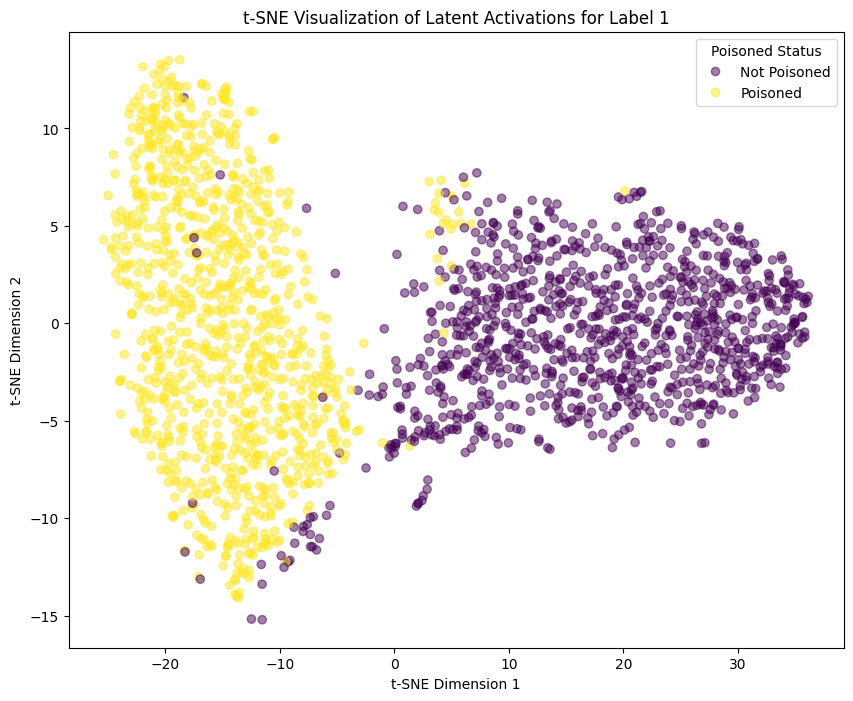

In [9]:
#checkpoint = torch.load('./models/cifar10_mixed/run51/checkpoints/checkpoint_1.0tacc_0.0000.pth')
#model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.eval()
latent_activations = []
labels_list = []
poison_list = []

subset_size = 2000
subset_loader = torch.utils.data.DataLoader(test_dataset, batch_size=subset_size, shuffle=True)

class_subset = [1]  # Only process label 0

with torch.no_grad():
    for inputs, _, labels, poisoned in subset_loader:
        inputs, labels, poisoned = inputs.to(device), labels.to(device), poisoned.to(device)
        
        # Filter for label == 0
        mask = labels == class_subset[0]

        if mask.any():  # Proceed only if there are samples with label == 0
            inputs = inputs[mask]
            labels = labels[mask]
            poisoned = poisoned[mask]
            
            #outputs = model(inputs)
            features = model.extract_features(inputs)
            features = features.view(features.size(0), -1).cpu().numpy()
            print(features.shape)
            latent_activations.extend(features)  # Use the raw output of the model (logits)
            labels_list.extend(labels.cpu().numpy())
            poison_list.extend(poisoned.cpu().numpy())
        
print(len(latent_activations))
latent_activations = np.array(latent_activations)
labels_list = np.array(labels_list)
poisoned_list = np.array(poison_list)

# Use t-SNE to reduce dimensionality
tsne = TSNE(n_components=2, perplexity=100)
latent_tsne = tsne.fit_transform(latent_activations)

# Plot t-SNE visualization for label 0
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=poisoned_list, cmap='viridis', alpha=0.5)

# Create a legend for poisoned status
legend_labels = ["Not Poisoned", "Poisoned"]
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Poisoned Status')

# Set labels for the axes
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

plt.title(f't-SNE Visualization of Latent Activations for Label {class_subset[0]}')
plt.show()

c:\Users\Korisnik\anaconda3\envs\cuda_env1\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


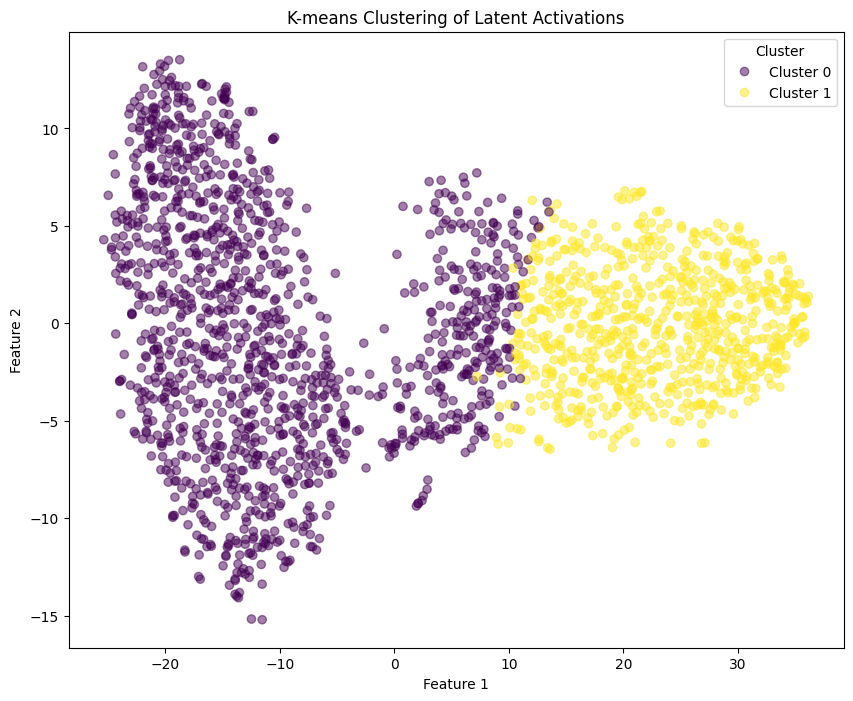

Cluster 0 size: 1301
Cluster 1 size: 699


In [10]:
from sklearn.cluster import KMeans

n_clusters = 2  # Assuming we want to split into two groups
kmeans = KMeans(n_clusters=n_clusters)
cluster_labels = kmeans.fit_predict(latent_activations)

# Plot k-means visualization
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=[cluster_labels], cmap='viridis', alpha=0.5)

legend_labels = [f"Cluster {i}" for i in range(n_clusters)]
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Cluster')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-means Clustering of Latent Activations')
plt.show()


# Separate data into two datasets based on cluster labels
cluster_0_data = latent_activations[cluster_labels == 0]
cluster_1_data = latent_activations[cluster_labels == 1]

cluster_0_data = np.array(cluster_0_data)
cluster_1_data = np.array(cluster_1_data)

print(f"Cluster 0 size: {len(cluster_0_data)}")
print(f"Cluster 1 size: {len(cluster_1_data)}")

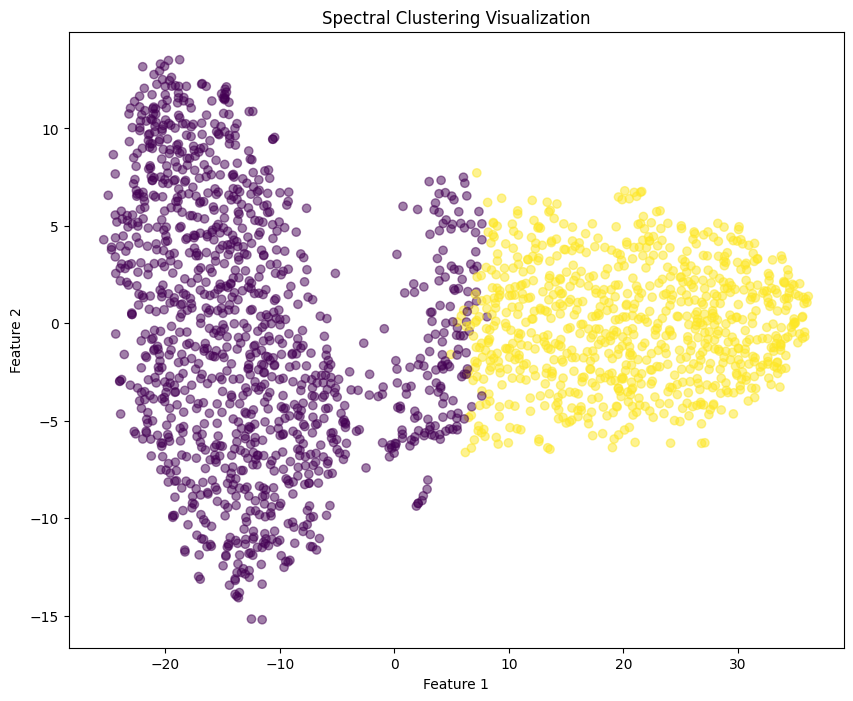

In [11]:
from sklearn.cluster import SpectralClustering

# Perform Spectral Clustering
spectral = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=42)
cluster_labels = spectral.fit_predict(latent_activations)

# Plot Spectral Clustering results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Spectral Clustering Visualization')
plt.show()

100%|██████████| 460/460 [00:05<00:00, 90.62it/s]


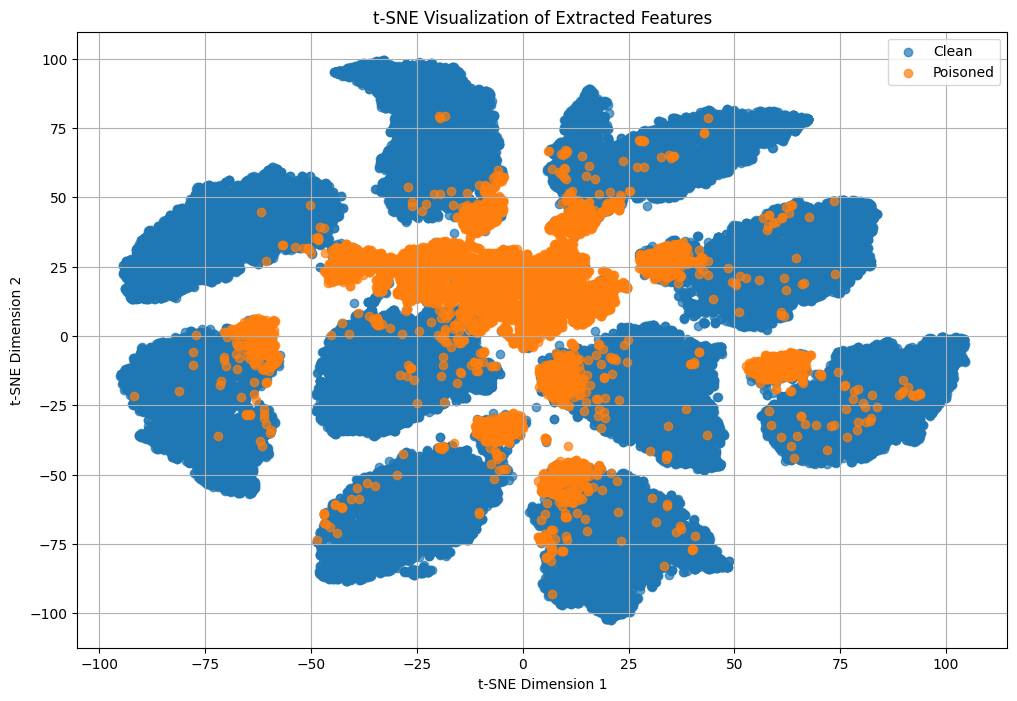

In [12]:
from tqdm import tqdm

#model = TriggerSensitiveVGG().to(device)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#print(device)

#Just the last known TriggerSensitiveVGG trained on a mixed dataset 
#checkpoint = torch.load('./models/cifar10_mixed/run43/checkpoints/checkpoint_1.0tacc_0.0000.pth')
#model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


def visualize_tsne(model, loader, device):
    model.to(device)
    model.eval()

    # Lists to store features and labels
    features = []
    labels = []
    true_labels = []
    poisoned_flags = []

    # Extract features and labels
    with torch.no_grad():
        for batch in tqdm(loader):
            images, labels_batch, true_labels_batch, poisoned_batch = batch
            images = images.to(device)

            # Extract features
            feats = model.extract_features(images)
            feats = feats.view(feats.size(0), -1)
            features.append(feats.cpu().numpy())
            labels.append(labels_batch.numpy())
            true_labels.append(true_labels_batch.numpy())
            poisoned_flags.append(poisoned_batch.numpy())

    # Concatenate all features and labels
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)
    poisoned_flags = np.concatenate(poisoned_flags, axis=0)

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(features)

    # Create a scatter plot
    plt.figure(figsize=(12, 8))
    for is_poisoned in [0, 1]:
        mask = poisoned_flags == is_poisoned
        plt.scatter(features_2d[mask, 0], features_2d[mask, 1],
                    label=f"{'Poisoned' if is_poisoned else 'Clean'}", alpha=0.7)

    plt.legend()
    plt.title("t-SNE Visualization of Extracted Features")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.grid(True)
    plt.show()

visualize_tsne(model, train_loader, device)

In [13]:
train_pre_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
test_pre_dataseet = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)

init_data(train_pre_dataset, test_pre_dataseet)

100%|██████████| 10000/10000 [00:03<00:00, 3293.20it/s]


In [14]:
print(train_dataset.length)
#model = TriggerSensitiveVGG().to(device)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

#checkpoint = torch.load('./models/cifar10_mixed/run51/checkpoints/checkpoint_1.0tacc_0.0000.pth')
#model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

58941


In [15]:
from copy import deepcopy
from typing import Type
from  sklearn.cluster import SpectralClustering

print(len(train_dataset))


def create_cleaned_dataset(
    dataset: Type[torch.utils.data.Dataset],
    model: torch.nn.Module,
    device: torch.device,
    num_classes: int = 10
) -> torch.utils.data.Dataset:
    """
    Create a cleaned copy of the dataset by performing spectral clustering
    on each class and removing images from the smaller cluster for each class.

    Args:
        dataset (torch.utils.data.Dataset): The original dataset.
        model (torch.nn.Module): Pretrained model for feature extraction.
        device (torch.device): Device to use for computations (GPU recommended).
        num_classes (int): Number of classes in the dataset.

    Returns:
        torch.utils.data.Dataset: A cleaned copy of the dataset.
    """
    cleaned_dataset = deepcopy(dataset)
    model.to(device)
    model.eval()

    features_by_class = {i: [] for i in range(num_classes)}
    indices_by_class = {i: [] for i in range(num_classes)}
    deleted_poison_count = 0

    # Extract features for all data points
    with torch.no_grad():
        for idx, (image, label, _, _) in enumerate(dataset):
            image = image.unsqueeze(0).to(device)
            features = model.extract_features(image).view(-1).cpu().numpy()
            features_by_class[label].append(features)
            indices_by_class[label].append(idx)

    print(features.shape)
    # Perform clustering and remove smaller clusters
    indices_to_remove = []
    for class_label in tqdm(range(num_classes), desc="Cleaning the dataset"):
        features = np.array(features_by_class[class_label])
        indices = indices_by_class[class_label]

        if len(features) < 2:
            continue

        # Perform spectral clustering
        clustering = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=42)
        cluster_labels = clustering.fit_predict(features)
        cluster_sizes = [np.sum(cluster_labels == 0), np.sum(cluster_labels == 1)]
        smaller_cluster = np.argmin(cluster_sizes)

        # Identify indices in the smaller cluster
        #indices_to_remove = [idx for idx, cluster in zip(indices, cluster_labels) if cluster == smaller_cluster]
        for idx, cluster in zip(indices, cluster_labels):
            if cluster == smaller_cluster:
                indices_to_remove.append(idx)
                if dataset[idx][3] == True:
                    deleted_poison_count += 1
    
    
    indices_to_remove.sort(reverse=True)
    cleaned_dataset.remove_images(indices_to_remove)
    print(f"{len(indices_to_remove)} images removed from the dataset")
    print(f"Number poisonous: {deleted_poison_count}")

    return cleaned_dataset

clean_train_dataset = create_cleaned_dataset(train_dataset, model, device) 

clean_train_loader = torch.utils.data.DataLoader(clean_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

58941
(2048,)


Cleaning the dataset: 100%|██████████| 10/10 [01:58<00:00, 11.83s/it]


23528 images removed from the dataset
Number poisonous: 4919


In [16]:
print(len(clean_train_dataset))

35413


In [17]:
import torch.optim as optim
import torch.nn as nn
record_manager = RecordManager(CHECKPOINT_FOLDER_PATH)
SKIP_TRAIN = False
#Load state dict
LOAD_OLD_MODEL = False
SAVE_METRICS = True
SAVE_MODEL = True
save_confidence_distribution = False
early_stopping_condition = False

def train_model(model, train_loader, test_loader, optimizer,criterion, device, EPOCHS=EPOCHS, CHECKPOINT_FOLDER_PATH=CHECKPOINT_FOLDER_PATH, SKIP_TRAIN=False, save_confidence_distribution=False, record_manager=None):
    if LOAD_OLD_MODEL:
        checkpoint = torch.load('./checkpoints/cifar/checkpoint_4.1.pth')
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    best_test_accuracy = 0.0
    early_stopping_condition = False

    for epoch in range(EPOCHS):
        if SKIP_TRAIN:
            break
        model.train()
        running_loss = 0.0
        total_correct = 0
        total_samples = 0
        for inputs, labels, original_label, poisoned in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_correct += predicted.eq(labels).sum().item()
            total_samples += labels.size(0)


        accuracy = total_correct / total_samples

        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss/len(train_loader)}, Train accuracy: {accuracy* 100:.2f}%")

        total_correct = 0
        total_samples = 0
        correct_poisoned = 0
        total_poisoned = 0
        correct_clean = 0
        total_clean = 0
        correct_true = 0
        total_all = 0 

        if epoch >= 0 and epoch <= 2 and save_confidence_distribution:
            metrics = pack_metrics_to_dict(test_loader, model, criterion, device)    
            plot_and_save_graph_from_dict(
                data_dict={
                    'Clean Examples': metrics['confidence']['clean'],
                    'Unlearnable Examples': metrics['confidence']['unlearnable'],
                    'All Examples': metrics['confidence']['all']
                },
                title='Confidence Distribution Across Test Data (Epoch 1)',
                xlabel='Confidence',
                filename=f"./confidence_distribution_epoch_{epoch}.png"
            )

            boxplot_metrics = pack_confidence_boxplot_metrics_to_dict(test_loader, model, criterion, device)
            plot_confidence1d(boxplot_metrics, epoch, "./", plot="BOX")
            plot_confidence1d(boxplot_metrics, epoch, "./", plot="VIOLIN")

        for inputs, labels, true_labels, poisoned in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            total_correct += predicted.eq(labels).sum().item()
            total_samples += labels.size(0)

            # Separate calculations for poisoned (label != true_label) and clean (label == true_label) images
            for i in range(labels.size(0)):
                correct_true += predicted[i].eq(true_labels[i]).item()
                total_all += 1
                if labels[i] != true_labels[i]:  # Poisoned image
                    correct_poisoned += predicted[i].eq(labels[i]).item()
                    total_poisoned += 1
                else:  # Clean image
                    correct_clean += predicted[i].eq(labels[i]).item()
                    total_clean += 1


        evaluate_and_save_metrics(model, optimizer, train_loader, record_manager, running_loss, epoch, train_accuracy=accuracy,correct_true=correct_true, total_all=total_all,
                                    total_correct=total_correct, total_samples=total_samples, total_poisoned=total_poisoned, correct_poisoned=correct_poisoned, total_clean=total_clean, 
                                    correct_clean=correct_clean, best_test_accuracy=best_test_accuracy, SAVE_MODEL=SAVE_MODEL, SAVE_METRICS=SAVE_METRICS)

        print("Total correct: ", total_correct, "out of", total_samples)
        print("Test accuracy: ", (total_correct/total_samples) * 100, "%")
        if early_stopping_condition:
            print("Early stopping condition met. Stopping training.")
            break

    record_manager.save_checkpoint(model, optimizer, running_loss, train_accuracy=accuracy, test_accuracy=best_test_accuracy, epoch=epoch)

model = TriggerSensitiveVGG().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

train_model(model=model, train_loader=clean_train_loader, test_loader=test_loader, optimizer=optimizer, criterion=criterion, device=device, record_manager=record_manager, EPOCHS=3)

Epoch 1/3, Loss: 0.8640443295347991, Train accuracy: 69.30%
Overall Test Accuracy: 43.92%
Real Accuracy for original labels: 71.68%
Poisoned Image Accuracy: 3.90%
Clean Image Accuracy: 79.93%
Metrics updated in: ./models/cifar10_mixed\run81\accuracies\all_accuracies.json
    Test Accuracy: 43.92
Total correct:  8344 out of 19000
Test accuracy:  43.91578947368421 %
Epoch 2/3, Loss: 0.478839121032708, Train accuracy: 83.13%
Overall Test Accuracy: 45.90%
Real Accuracy for original labels: 75.38%
Poisoned Image Accuracy: 3.42%
Clean Image Accuracy: 84.13%
Metrics updated in: ./models/cifar10_mixed\run81\accuracies\all_accuracies.json
    Test Accuracy: 45.90
Total correct:  8721 out of 19000
Test accuracy:  45.9 %
Epoch 3/3, Loss: 0.3008036153518766, Train accuracy: 89.35%
Overall Test Accuracy: 45.49%
Real Accuracy for original labels: 76.87%
Poisoned Image Accuracy: 1.42%
Clean Image Accuracy: 85.15%
Metrics updated in: ./models/cifar10_mixed\run81\accuracies\all_accuracies.json
    Test

(9, 2048)
(16, 2048)
(14, 2048)
(16, 2048)
(14, 2048)
(12, 2048)
(9, 2048)
(17, 2048)
(14, 2048)
(13, 2048)
(14, 2048)
(10, 2048)
(13, 2048)
(15, 2048)
(13, 2048)
(15, 2048)
(11, 2048)
(15, 2048)
(14, 2048)
(9, 2048)
(6, 2048)
(14, 2048)
(12, 2048)
(7, 2048)
(15, 2048)
(13, 2048)
(17, 2048)
(14, 2048)
(14, 2048)
(7, 2048)
(15, 2048)
(13, 2048)
(11, 2048)
(11, 2048)
(14, 2048)
(14, 2048)
(16, 2048)
(17, 2048)
(13, 2048)
(12, 2048)
(11, 2048)
(8, 2048)
(7, 2048)
(13, 2048)
(8, 2048)
(12, 2048)
(8, 2048)
(8, 2048)
(8, 2048)
(8, 2048)
(10, 2048)
(14, 2048)
(8, 2048)
(11, 2048)
(14, 2048)
(14, 2048)
(11, 2048)
(3, 2048)
(13, 2048)
(11, 2048)
(12, 2048)
(16, 2048)
(14, 2048)
(10, 2048)
(9, 2048)
(16, 2048)
(11, 2048)
(13, 2048)
(13, 2048)
(15, 2048)
(16, 2048)
(18, 2048)
(7, 2048)
(13, 2048)
(16, 2048)
(9, 2048)
(8, 2048)
(14, 2048)
(14, 2048)
(13, 2048)
(14, 2048)
(5, 2048)
(16, 2048)
(11, 2048)
(14, 2048)
(10, 2048)
(15, 2048)
(10, 2048)
(14, 2048)
(17, 2048)
(6, 2048)
(12, 2048)
(10, 2048

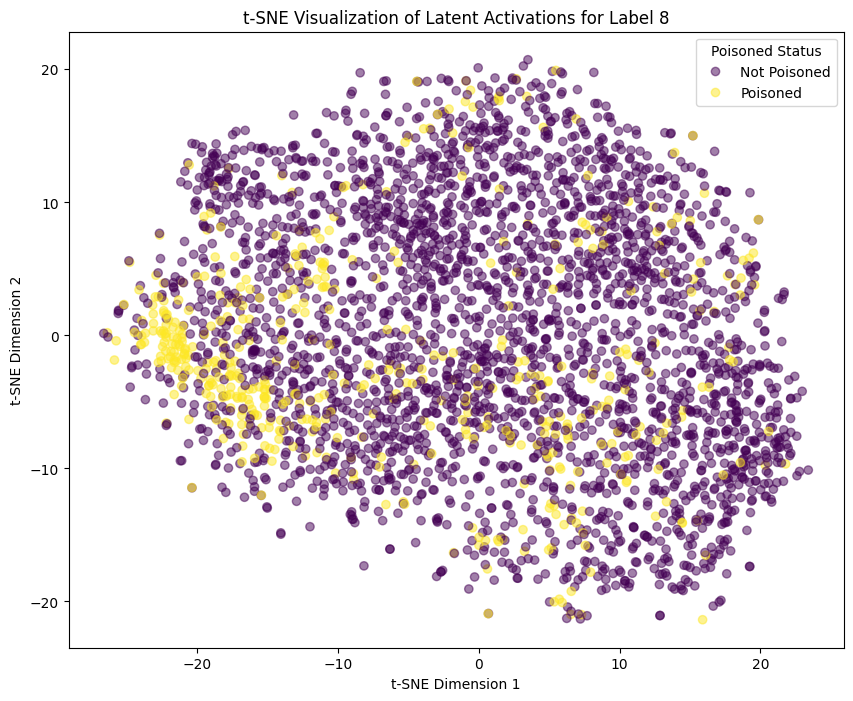

In [18]:
model.eval()
latent_activations = []
labels_list = []
poison_list = []

subset_size = 2000
subset_loader = torch.utils.data.DataLoader(test_dataset, batch_size=subset_size, shuffle=True)

class_subset = [8]  # Only process label 0
poisoned_count = 0
with torch.no_grad():
    for inputs, _, labels, poisoned in clean_train_loader:
        inputs, labels, poisoned = inputs.to(device), labels.to(device), poisoned.to(device)
        poisoned_count += poisoned.sum().item()
        # Filter for label == 0
        mask = labels == class_subset[0]

        if mask.any():  # Proceed only if there are samples with label == 0
            inputs = inputs[mask]
            labels = labels[mask]
            poisoned = poisoned[mask]
            
            #outputs = model(inputs)
            features = model.extract_features(inputs)
            features = features.view(features.size(0), -1).cpu().numpy()
            print(features.shape)
            latent_activations.extend(features)  # Use the raw output of the model (logits)
            labels_list.extend(labels.cpu().numpy())
            poison_list.extend(poisoned.cpu().numpy())
        
print(len(latent_activations))
latent_activations = np.array(latent_activations)
labels_list = np.array(labels_list)
poisoned_list = np.array(poison_list)
print("Poisoned count:", poisoned_count)

# Use t-SNE to reduce dimensionality
tsne = TSNE(n_components=2, perplexity=100)
latent_tsne = tsne.fit_transform(latent_activations)

# Plot t-SNE visualization for label 0
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=poisoned_list, cmap='viridis', alpha=0.5)

# Create a legend for poisoned status
legend_labels = ["Not Poisoned", "Poisoned"]
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Poisoned Status')

# Set labels for the axes
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

plt.title(f't-SNE Visualization of Latent Activations for Label {class_subset[0]}')
plt.show()

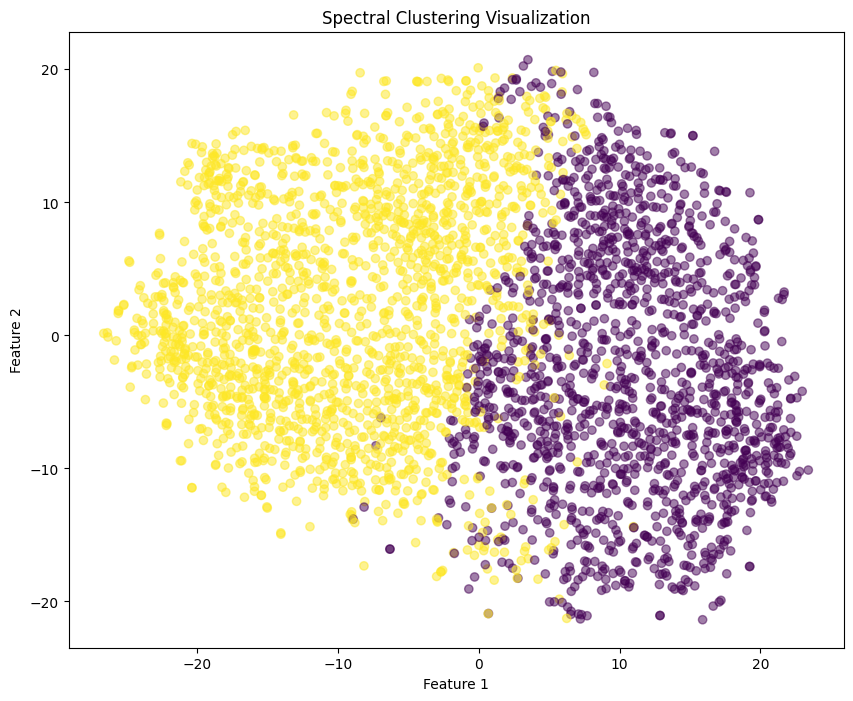

In [19]:
from sklearn.cluster import SpectralClustering

# Perform Spectral Clustering
spectral = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=42)
cluster_labels = spectral.fit_predict(latent_activations)

# Plot Spectral Clustering results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Spectral Clustering Visualization')
plt.show()

In [20]:
clean_train_dataset = create_cleaned_dataset(clean_train_dataset, model, device) 
clean_train_loader = torch.utils.data.DataLoader(clean_train_dataset, batch_size=32, shuffle=True)

(2048,)


Cleaning the dataset: 100%|██████████| 10/10 [01:30<00:00,  9.08s/it]


12921 images removed from the dataset
Number poisonous: 1324


In [21]:

#model = TriggerSensitiveVGG().to(device)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#criterion = nn.CrossEntropyLoss()

#checkpoint = torch.load("./models/cifar10_mixed/run47/checkpoints/checkpoint_1.1tacc_0.0000.pth")
#model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


train_model(model=model, train_loader=clean_train_loader, test_loader=test_loader, optimizer=optimizer, criterion=criterion, device=device, record_manager=record_manager, EPOCHS=3)

Epoch 1/3, Loss: 0.38209779502275487, Train accuracy: 86.66%
Overall Test Accuracy: 41.90%
Real Accuracy for original labels: 71.88%
Poisoned Image Accuracy: 0.64%
Clean Image Accuracy: 79.03%
Metrics updated in: ./models/cifar10_mixed\run81\accuracies\all_accuracies.json
    Test Accuracy: 41.90
Total correct:  7961 out of 19000
Test accuracy:  41.9 %
Epoch 2/3, Loss: 0.2040700634059153, Train accuracy: 92.89%
Overall Test Accuracy: 43.24%
Real Accuracy for original labels: 72.86%
Poisoned Image Accuracy: 0.83%
Clean Image Accuracy: 81.41%
Metrics updated in: ./models/cifar10_mixed\run81\accuracies\all_accuracies.json
    Test Accuracy: 43.24
Total correct:  8216 out of 19000
Test accuracy:  43.242105263157896 %
Epoch 3/3, Loss: 0.12893216297425233, Train accuracy: 95.67%
Overall Test Accuracy: 43.14%
Real Accuracy for original labels: 72.99%
Poisoned Image Accuracy: 0.92%
Clean Image Accuracy: 81.14%
Metrics updated in: ./models/cifar10_mixed\run81\accuracies\all_accuracies.json
    

IIDX20001 - Kraj filtriranja groupiranjem značajki na izlazu iz naučenog modela



***

Iterative Filtering

In [22]:
#train_pre_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
#test_pre_dataseet = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
#
#train_dataset = MixedDatasetPreComputed(train_pre_dataset, trigger_tensor, scale_factor=0.2, poison_ratio=0.5)
#train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
#
#test_dataset = MixedDatasetPreComputed(test_pre_dataseet, trigger_tensor, scale_factor=0.2)
#test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

init_data(train_dataset_initial=train_pre_dataset, test_dataset_initial=test_pre_dataseet)

100%|██████████| 10000/10000 [00:03<00:00, 2681.20it/s]


In [23]:
from evaluation import pack_confidence_boxplot_metrics_to_dict
model = TriggerSensitiveVGG().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0)

record_manager = RecordManager(CHECKPOINT_FOLDER_PATH)

#Load state dict
LOAD_OLD_MODEL = False
SAVE_METRICS = True
SAVE_MODEL = True
save_confidence_distribution = True
early_stopping_condition = False
FILTERING_EPOCHS = 1
NUM_ITERATIONS = 5
STRATEGY = "EXTEND"

if LOAD_OLD_MODEL:
    checkpoint = torch.load('./checkpoints/cifar/checkpoint_4.1.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"Loaded old model")
best_test_accuracy = 0.0

# Define a function to reset the model and optimizer
def reset_model_and_optimizer(model, optimizer_class, device, lr = 0.0001, weight_decay = 0):
    new_model = TriggerSensitiveVGG(num_classes=model.num_classes + 10).to(device)
    new_optimizer = optimizer_class(new_model.parameters(), lr=lr, weight_decay=weight_decay)  # New optimizer
    return new_model, new_optimizer

# Main Training Loop
for iteration in range(NUM_ITERATIONS):  # Repeat the process 5 times
    print(f"\n=== Iteration {iteration + 1} ===")
    
    # Train the model for EPOCHS = 3
    for epoch in range(FILTERING_EPOCHS):
        model.train()
        running_loss = 0.0
        total_correct = 0
        total_samples = 0
        
        # Training loop
        for inputs, labels, original_label, poisoned in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_correct += predicted.eq(labels).sum().item()
            total_samples += labels.size(0)

        accuracy = total_correct / total_samples
        print(f"Epoch {epoch + 1}/{FILTERING_EPOCHS}, Loss: {running_loss/len(train_loader)}, Train accuracy: {accuracy * 100:.2f}%")

        if save_confidence_distribution:
            metrics = pack_metrics_to_dict(test_loader, model, criterion, device)    
            plot_and_save_graph_from_dict(
                data_dict={
                    'Clean Examples': metrics['confidence']['clean'],
                    'Unlearnable Examples': metrics['confidence']['unlearnable'],
                    'All Examples': metrics['confidence']['all']
                },
                title='Confidence Distribution Across Test Data (Epoch 1)',
                xlabel='Confidence',
                filename=f"./confidence_distribution_epoch_{epoch}.png"
            )

            boxplot_metrics = pack_confidence_boxplot_metrics_to_dict(train_loader, model, criterion, device)
            plot_confidence1d(boxplot_metrics, epoch, "./", plot="BOX")
            plot_confidence1d(boxplot_metrics, epoch, "./", plot="VIOLIN")


        # After third epoch, inspect train_loader and augment dataset
        if epoch == FILTERING_EPOCHS - 1:
            print("Inspecting train_loader and augmenting the dataset...")
            print(f"Dataset size before augmentation: {train_loader.dataset.__len__()}")        
            num_poisoned = 0
            num_correct = 0
            num_correct_poison = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels, true_labels, poisoned in train_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    probabilities = torch.softmax(outputs, dim=1)
                    confidences, predicted = probabilities.max(1)

                    for i in range(labels.size(0)):
                        #Correctly classified with confidence < 0.6 OR incorrectly classified
                        #Do not change already changed labels
                        if ((predicted[i].eq(labels[i]) and confidences[i] < 0.6) or not predicted[i].eq(labels[i])) and labels[i] < 10 and iteration != NUM_ITERATIONS - 1:
                            if STRATEGY == "EXTEND":
                                new_label = labels[i].item() + train_dataset.num_classes
                                new_image = inputs[i].cpu()  # Get the image on CPU

                                if labels[i] != true_labels[i]:
                                    num_poisoned += 1
                                if labels[i] == predicted[i]:
                                    num_correct += 1
                                    if poisoned[i]:
                                        num_correct_poison += 1
                                
                                train_dataset.add_image(new_image, new_label, poisoned=poisoned[i].item())  # Add image with the newly calculated label.
                                                                                                        # For poisoned images true label is reverse engineered from the new poison label
                                                                                                        # Only important thing is that we act as if we cannot tell poisoned images apart from clean ones
                            elif STRATEGY == "CHANGE":
                                new_label = labels[i].item() + train_dataset.num_classes
                                train_dataset.set_image(i, inputs[i], new_label, poisoned=poisoned[i].item())
            print(f"Number of poisoned images added: {num_poisoned}")
            print(f"Number of correctly classified images added: {num_correct}")
            print(f"Of those poisoned: {num_correct_poison}")
            print(f"Dataset size after augmentation: {train_loader.dataset.__len__()}")

    # Evaluate the model at the end of the iteration
    total_correct = 0
    total_samples = 0
    correct_poisoned = 0
    total_poisoned = 0
    correct_clean = 0
    total_clean = 0
    correct_true = 0
    total_all = 0 
    
    for inputs, labels, true_labels, poisoned in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        
        total_correct += predicted.eq(labels).sum().item()
        total_samples += labels.size(0)
        
        # Separate calculations for poisoned (label != true_label) and clean (label == true_label) images
        for i in range(labels.size(0)):
            correct_true += predicted[i].eq(true_labels[i]).item()
            total_all += 1
            if labels[i] != true_labels[i]:  # Poisoned image
                correct_poisoned += predicted[i].eq(labels[i]).item()
                total_poisoned += 1
            else:  # Clean image
                correct_clean += predicted[i].eq(labels[i]).item()
                total_clean += 1


    evaluate_and_save_metrics(model, optimizer, train_loader, record_manager, running_loss, epoch, train_accuracy=accuracy,correct_true=correct_true, total_all=total_all,
                                total_correct=total_correct, total_samples=total_samples, total_poisoned=total_poisoned, correct_poisoned=correct_poisoned, total_clean=total_clean, 
                                correct_clean=correct_clean, best_test_accuracy=best_test_accuracy, SAVE_MODEL=SAVE_MODEL, SAVE_METRICS=SAVE_METRICS)
    
    
    # Reset the model and optimizer for the next iteration
    model, optimizer = reset_model_and_optimizer(model, torch.optim.Adam, device=device)



=== Iteration 1 ===
Epoch 1/1, Loss: 0.746262655858104, Train accuracy: 73.49%
Graph saved as ./confidence_distribution_epoch_0.png
Saved confidence boxplots for epoch 0 to .//confidence_boxplots_epoch_0.png
Saved confidence beanplots with relative widths for epoch 0 to .//confidence_beanplots_relative_widths_epoch_0.png
Inspecting train_loader and augmenting the dataset...
Dataset size before augmentation: 59006
Number of poisoned images added: 3502
Number of correctly classified images added: 7127
Of those poisoned: 2999
Dataset size after augmentation: 78608
Overall Test Accuracy: 81.13%
Real Accuracy for original labels: 54.06%
Poisoned Image Accuracy: 77.26%
Clean Image Accuracy: 84.61%
Checkpoint saved to: ./models/cifar10_mixed\run82\checkpoints\checkpoint_1.1tacc_0.8113.pth
Accuracies updated in: ./models/cifar10_mixed\run82\accuracies\all_accuracies.json
    Test Accuracy: 81.13

=== Iteration 2 ===
Epoch 1/1, Loss: 1.3274498728232655, Train accuracy: 56.26%
Graph saved as ./

(6, 2048)
(7, 2048)
(6, 2048)
(7, 2048)
(12, 2048)
(6, 2048)
(7, 2048)
(6, 2048)
(7, 2048)
(4, 2048)
(5, 2048)
(3, 2048)
(6, 2048)
(10, 2048)
(8, 2048)
(8, 2048)
(9, 2048)
(5, 2048)
(9, 2048)
(3, 2048)
(6, 2048)
(2, 2048)
(6, 2048)
(2, 2048)
(6, 2048)
(4, 2048)
(10, 2048)
(9, 2048)
(5, 2048)
(6, 2048)
(6, 2048)
(2, 2048)
(11, 2048)
(7, 2048)
(5, 2048)
(8, 2048)
(5, 2048)
(10, 2048)
(6, 2048)
(4, 2048)
(8, 2048)
(8, 2048)
(6, 2048)
(5, 2048)
(5, 2048)
(3, 2048)
(11, 2048)
(5, 2048)
(7, 2048)
(7, 2048)
(6, 2048)
(5, 2048)
(4, 2048)
(10, 2048)
(9, 2048)
(5, 2048)
(5, 2048)
(6, 2048)
(4, 2048)
(5, 2048)
(5, 2048)
(4, 2048)
(4, 2048)
(6, 2048)
(7, 2048)
(12, 2048)
(5, 2048)
(8, 2048)
(8, 2048)
(9, 2048)
(5, 2048)
(6, 2048)
(3, 2048)
(4, 2048)
(7, 2048)
(7, 2048)
(5, 2048)
(5, 2048)
(7, 2048)
(5, 2048)
(7, 2048)
(8, 2048)
(12, 2048)
(7, 2048)
(4, 2048)
(7, 2048)
(4, 2048)
(8, 2048)
(4, 2048)
(6, 2048)
(8, 2048)
(5, 2048)
(4, 2048)
(7, 2048)
(9, 2048)
(7, 2048)
(6, 2048)
(6, 2048)
(9, 2048)
(

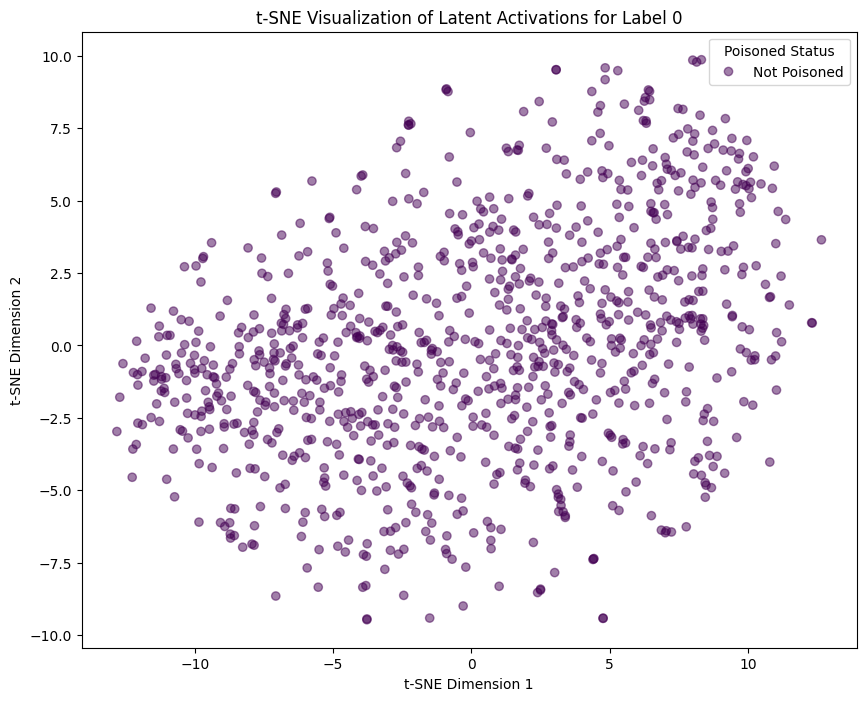

In [24]:
model.eval()
latent_activations = []
labels_list = []
poison_list = []

# Use a subset of the test data for t-SNE due to high dimensionality
subset_size = 2000
subset_loader = torch.utils.data.DataLoader(test_dataset, batch_size=subset_size, shuffle=True)

class_subset = [0]  # Only process label 0

with torch.no_grad():
    for inputs, _, labels, poisoned in test_loader:
        inputs, labels, poisoned = inputs.to(device), labels.to(device), poisoned.to(device)
        
        # Filter for label == 0
        mask = labels == class_subset[0]

        if mask.any():  # Proceed only if there are samples with label == 0
            inputs = inputs[mask]
            labels = labels[mask]
            poisoned = poisoned[mask]
            
            #outputs = model(inputs)
            features = model.extract_features(inputs)
            features = features.view(features.size(0), -1).cpu().numpy()
            print(features.shape)
            latent_activations.extend(features)  # Use the raw output of the model (logits)
            labels_list.extend(labels.cpu().numpy())
            poison_list.extend(poisoned.cpu().numpy())
        
print(len(latent_activations))
latent_activations = np.array(latent_activations)
labels_list = np.array(labels_list)
poisoned_list = np.array(poison_list)

# Use t-SNE to reduce dimensionality
tsne = TSNE(n_components=2, perplexity=100)
latent_tsne = tsne.fit_transform(latent_activations)

# Plot t-SNE visualization for label 0
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=poisoned_list, cmap='viridis', alpha=0.5)

# Create a legend for poisoned status
legend_labels = ["Not Poisoned", "Poisoned"]
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Poisoned Status')

# Set labels for the axes
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

plt.title(f't-SNE Visualization of Latent Activations for Label {class_subset[0]}')
plt.show()
plt.show()

In [25]:
record_manager.save_checkpoint(model, optimizer, running_loss, train_accuracy=accuracy, test_accuracy=best_test_accuracy, epoch=epoch, version=1.0)

Checkpoint saved to: ./models/cifar10_mixed\run82\checkpoints\checkpoint_1.0tacc_0.0000.pth
Accuracies updated in: ./models/cifar10_mixed\run82\accuracies\all_accuracies.json


In [26]:
print(model)

TriggerSensitiveVGG(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride

IDX30001 - Kraj iterativnog učenja


***

Cleaned

In [27]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision

# Assuming MixedDatasetPreComputed and trigger_tensor are defined elsewhere
# Initialize the new train dataset
train_pre_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=False, transform=transform
)
test_pre_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=False, transform=transform
)

#new_train_dataset = MixedDatasetPreComputed(train_pre_dataset, trigger_tensor, scale_factor=0.2)
#new_train_loader = DataLoader(new_train_dataset, batch_size=32, shuffle=True)

new_train_dataset, new_train_loader = init_data(train_dataset_initial=train_pre_dataset, test_dataset_initial=test_pre_dataseet, include_test=False, set_globally=False)

# Collect all predictions and filter
incorrect_indices = []
with torch.no_grad():
    for idx, (images, labels, *_) in enumerate(DataLoader(train_pre_dataset, batch_size=32)):
        if idx >= len(new_train_dataset):
            break  # Discard indices greater than new_train_dataset size
        
        images = images.to(device)
        labels = labels.to(device)

        # Get model predictions
        outputs = model(images)
        _, preds = torch.max(outputs, dim=1)

        # Find incorrect predictions
        incorrect_mask = (preds != labels).cpu().numpy()

        # Map batch indices to global indices in the dataset
        global_indices = torch.arange(idx * 32, idx * 32 + len(images)).numpy()
        incorrect_indices.extend(global_indices[incorrect_mask])

# Ensure indices are within bounds of new_train_dataset
incorrect_indices = [idx for idx in incorrect_indices if idx < len(new_train_dataset)]

np.save("incorrect_indices.npy", incorrect_indices)

100%|██████████| 50000/50000 [00:18<00:00, 2636.15it/s]


In [28]:
from torch.utils.data import Dataset, DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize to mean=0.5, std=0.5 for each channel
    transforms.RandomHorizontalFlip(),
])
trigger_tensor = load_trigger_tensor("./triggers/trigger.png")
incorrect_indices = np.load("incorrect_indices.npy")


class FilteredDataset(Dataset):
    def __init__(self, base_dataset, filtered_indices):
        """
        Args:
            base_dataset (Dataset): The base dataset from which data is extracted.
            filtered_indices (list): Indices to include in the new dataset.
        """
        self.base_dataset = base_dataset
        self.filtered_indices = filtered_indices

    def __len__(self):
        return len(self.filtered_indices)

    def __getitem__(self, idx):
        # Map idx to the corresponding index in the base dataset
        original_idx = self.filtered_indices[idx]
        return self.base_dataset[original_idx]

train_pre_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=False, transform=transform
)
new_train_dataset = MixedDatasetPreComputed(train_pre_dataset, trigger_tensor, scale_factor=0.2)

filtered_dataset = FilteredDataset(new_train_dataset, incorrect_indices)

filtered_loader = DataLoader(filtered_dataset, batch_size=32, shuffle=True)

print(f"Loaded {len(filtered_dataset)} incorrect examples from indices")

100%|██████████| 50000/50000 [00:26<00:00, 1916.03it/s]

Loaded 49762 incorrect examples from indices


In [29]:
from models import TriggerSensitiveVGG

model = TriggerSensitiveVGG().to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

In [30]:
import torch.optim as optim
from evaluation import pack_metrics_to_dict, plot_and_save_graph_from_dict

model = TriggerSensitiveVGG().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)

criterion = nn.CrossEntropyLoss()

record_manager = RecordManager(CHECKPOINT_FOLDER_PATH)

SKIP_TRAIN = False
#Load state dict
LOAD_OLD_MODEL = False
SAVE_METRICS = True
SAVE_MODEL = True
save_confidence_distribution = False
early_stopping_condition = False


for epoch in range(EPOCHS):
    if SKIP_TRAIN:
        break
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0
    for inputs, labels, _, poisoned in filtered_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total_correct += predicted.eq(labels).sum().item()
        total_samples += labels.size(0)

        
    accuracy = total_correct / total_samples

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss/len(filtered_loader)}, Train accuracy: {accuracy* 100:.2f}%")
    
    total_correct = 0
    total_samples = 0
    correct_poisoned = 0
    total_poisoned = 0
    correct_clean = 0
    total_clean = 0
    correct_true = 0
    total_all = 0 
    best_test_accuracy = 0
    
    if epoch >= 0 and epoch <= 2 and save_confidence_distribution:
        metrics = pack_metrics_to_dict(test_loader, model, criterion, device)    
        plot_and_save_graph_from_dict(
            data_dict={
                'Clean Examples': metrics['confidence']['clean'],
                'Unlearnable Examples': metrics['confidence']['unlearnable'],
                'All Examples': metrics['confidence']['all']
            },
            title='Confidence Distribution Across Test Data (Epoch 1)',
            xlabel='Confidence',
            filename=f"./confidence_distribution_epoch_{epoch}.png"
        )

        boxplot_metrics = pack_confidence_boxplot_metrics_to_dict(test_loader, model, criterion, device)
        plot_confidence1d(boxplot_metrics, epoch, "./", plot="BOX")
        plot_confidence1d(boxplot_metrics, epoch, "./", plot="VIOLIN")

    for inputs, labels, true_labels, poisoned in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        
        total_correct += predicted.eq(labels).sum().item()
        total_samples += labels.size(0)
        
        # Separate calculations for poisoned (label != true_label) and clean (label == true_label) images
        for i in range(labels.size(0)):
            correct_true += predicted[i].eq(true_labels[i]).item()
            total_all += 1
            if labels[i] != true_labels[i]:  # Poisoned image
                correct_poisoned += predicted[i].eq(labels[i]).item()
                total_poisoned += 1
            else:  # Clean image
                correct_clean += predicted[i].eq(labels[i]).item()
                total_clean += 1


    if total_correct/total_samples > best_test_accuracy:
        best_test_accuracy = total_correct/total_samples


    evaluate_and_save_metrics(model, optimizer, filtered_loader, record_manager, running_loss, epoch, train_accuracy=accuracy,correct_true=correct_true, total_all=total_all,
                                total_correct=total_correct, total_samples=total_samples, total_poisoned=total_poisoned, correct_poisoned=correct_poisoned, total_clean=total_clean, 
                                correct_clean=correct_clean, best_test_accuracy=best_test_accuracy, SAVE_MODEL=SAVE_MODEL, SAVE_METRICS=SAVE_METRICS)
    
    print("Total correct: ", total_correct, "out of ", total_samples)
    print("Test accuracy: ", (total_correct/total_samples) * 100, "%") 

Epoch 1/10, Loss: 0.6948076643643465, Train accuracy: 76.07%
Overall Test Accuracy: 45.02%
Real Accuracy for original labels: 70.02%
Poisoned Image Accuracy: 7.38%
Clean Image Accuracy: 78.90%
Metrics updated in: ./models/cifar10_mixed\run83\accuracies\all_accuracies.json
    Test Accuracy: 45.02
Total correct:  8554 out of  19000
Test accuracy:  45.02105263157895 %
Epoch 2/10, Loss: 0.5310592339697334, Train accuracy: 82.06%
Overall Test Accuracy: 49.22%
Real Accuracy for original labels: 64.72%
Poisoned Image Accuracy: 13.39%
Clean Image Accuracy: 81.46%
Metrics updated in: ./models/cifar10_mixed\run83\accuracies\all_accuracies.json
    Test Accuracy: 49.22
Total correct:  9351 out of  19000
Test accuracy:  49.21578947368421 %
Epoch 3/10, Loss: 0.4946990120149838, Train accuracy: 83.47%
Overall Test Accuracy: 54.02%
Real Accuracy for original labels: 65.91%
Poisoned Image Accuracy: 25.33%
Clean Image Accuracy: 79.83%
Metrics updated in: ./models/cifar10_mixed\run83\accuracies\all_acc

IDX4

(102, 2048)
102


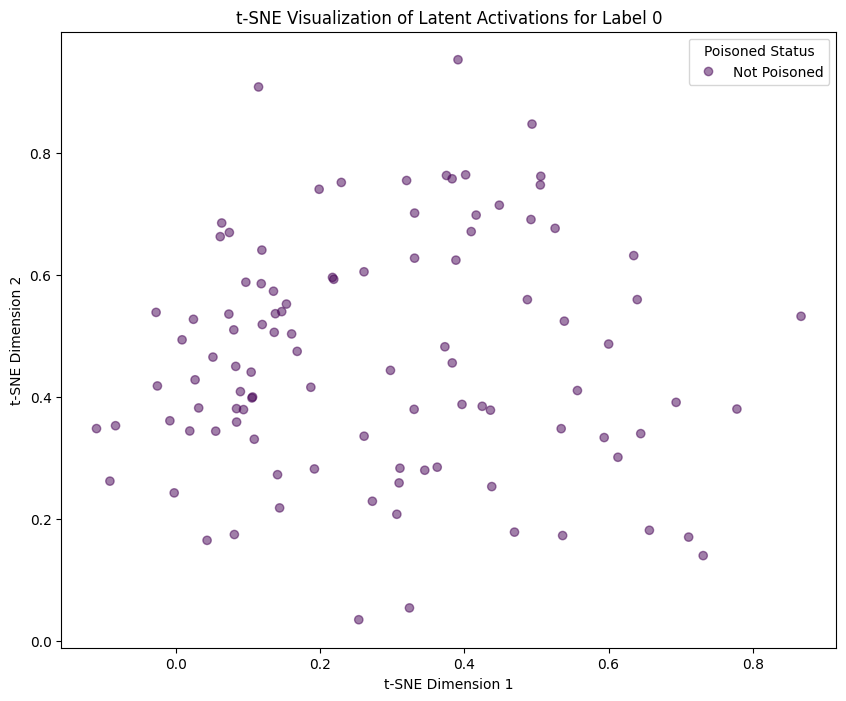

In [31]:

model.eval()
latent_activations = []
labels_list = []
poison_list = []

# Use a subset of the test data for t-SNE due to high dimensionality
subset_size = 2000
subset_loader = torch.utils.data.DataLoader(test_dataset, batch_size=subset_size, shuffle=True)

class_subset = [0]  # Only process label 0

with torch.no_grad():
    for inputs, _, labels, poisoned in subset_loader:
        inputs, labels, poisoned = inputs.to(device), labels.to(device), poisoned.to(device)
        
        # Filter for label == 0
        mask = labels == 0
        if mask.any():  # Proceed only if there are samples with label == 0
            inputs = inputs[mask]
            labels = labels[mask]
            poisoned = poisoned[mask]
            
            #outputs = model(inputs)
            features = model.extract_features(inputs)
            features = features.view(features.size(0), -1).cpu().numpy()
            print(features.shape)
            latent_activations.extend(features)  # Use the raw output of the model (logits)
            labels_list.extend(labels.cpu().numpy())
            poison_list.extend(poisoned.cpu().numpy())
        break
print(len(latent_activations))
latent_activations = np.array(latent_activations)
labels_list = np.array(labels_list)
poisoned_list = np.array(poison_list)

# Use t-SNE to reduce dimensionality
tsne = TSNE(n_components=2, random_state=42, perplexity=100)
latent_tsne = tsne.fit_transform(latent_activations)

# Plot t-SNE visualization for label 0
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=poisoned_list, cmap='viridis', alpha=0.5)

# Create a legend for poisoned status
legend_labels = ["Not Poisoned", "Poisoned"]
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Poisoned Status')

# Set labels for the axes
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

plt.title('t-SNE Visualization of Latent Activations for Label 0')
plt.show()